In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from tensorflow import keras 
import random
import shap
random.seed(1234)

In [2]:
# Our data is a fairly simple linear Model which is binarized for the Neural Net (second example)

xsize = 1000
X = np.random.rand(xsize,10)
# only X[:,0], X[:,4], X[:,1] and X[:,2] are relevant and their relevance is in that order
y = 5.*X[:,0] - 1. * X[:,1] - 0.5*X[:,2] - 4.*X[:,4] + 0.2*np.random.normal(size=xsize) 
yNN = (y> np.mean(y))*1



In [3]:
print(X[1,:])
print(y[1])

[0.32560299 0.84062395 0.7565769  0.40766571 0.69703986 0.98771961
 0.78391366 0.13525607 0.03564824 0.01240115]
-2.578284964623312


In [4]:
Lreg = LinearRegression()
reg = Lreg.fit(X,y)

In [5]:
print(reg.coef_)  # Seems alright!

[ 5.03227021 -0.98491023 -0.46733831 -0.01510975 -4.010105    0.00755014
  0.06053501  0.01342733  0.03963507  0.01369103]


## Let's try to code SHAP for ourselves

In [6]:
p = X.shape[1] # Number of Features
n = 100 # Sample size

We wish to sample from an extreme Beta-Distribution so that we get either very few or very many features. The first case shows the isolatd effect of a feature, the latter the interaction of a feature with all other ones.

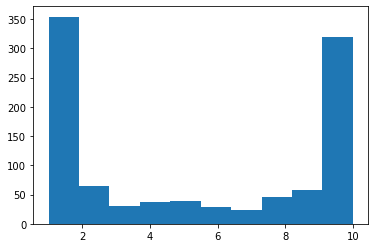

In [7]:
sample = np.random.beta(0.2, 0.2,1000)
sample = sample*X.shape[1]+1
sample = np.floor(sample).astype(int)
plt.hist(sample)
plt.show()

In [8]:
sel = np.random.choice(np.arange(p), size=3, replace=False)
print(sel)
r = np.arange(X.shape[1])
print(r[sel])
r[sel] = X.shape[1]
print(r)


[5 8 2]
[5 8 2]
[ 0  1 10  3  4 10  6  7 10  9]


In [9]:
def ChooseK(P):# P is integer of Feature number
    K =np.random.beta(0.2, 0.2,1)
    K = int(P*K+1)
    if K==P+1: # some degenerate cases
        K = K-1
    return(K)

In [10]:
ChooseK(X.shape[1])

1

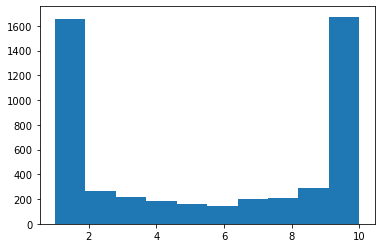

1.0 10.0
[10.  1. 10. ... 10.  2. 10.]


In [11]:
ks = np.empty(5000)
for ll in range(5000):
    ks[ll] =ChooseK(X.shape[1])
plt.hist(ks)
plt.show()
print(min(ks),max(ks))
print(ks)

In [12]:
def SwapFeatures(i,m,j,k):
    # take instance x_i, exchange k of its features randomly with the features of x_m including the jth Feature
    output = X[i,:].copy()
    
    if k == 1: # only change jth Feature
        output[j] = X[m,j].copy()
    
    else:
        Selection = np.random.choice(np.arange(X.shape[1]), size=k, replace=False)
        while (np.sum(Selection==j) ==0): # Make sure that j is included in selection
            Selection = np.random.choice(np.arange(X.shape[1]), size=k, replace=False)
        
        output[Selection] = X[m,Selection].copy()
    
    return(output)
        
        

In [13]:
print(X[np.arange(4),:])
print(SwapFeatures(2,3,0,2)) # the instance X[2,:] gets 2 features from X[3,:], including X[:,0]

[[0.22329783 0.24293256 0.47850778 0.30691128 0.70731265 0.3367444
  0.11633818 0.68483814 0.95988394 0.4648049 ]
 [0.32560299 0.84062395 0.7565769  0.40766571 0.69703986 0.98771961
  0.78391366 0.13525607 0.03564824 0.01240115]
 [0.89900452 0.6827307  0.92338234 0.14825063 0.63228141 0.72119109
  0.5562161  0.48758546 0.96804718 0.07669174]
 [0.13164895 0.752978   0.28861449 0.87942324 0.94475    0.48785544
  0.6229336  0.48610779 0.4491968  0.49542637]]
[0.13164895 0.6827307  0.92338234 0.14825063 0.63228141 0.72119109
 0.5562161  0.48758546 0.4491968  0.07669174]


In [14]:
def Compare(x_j, x_noj, Model):
    return(Model.predict(x_j.reshape(1, -1)) - Model.predict(x_noj.reshape(1, -1)))

In [15]:
reg.predict(np.arange(X.shape[1]).reshape(1, -1))

array([-17.1472173])

In [16]:
def CalcShap(X,i,j,M,Model):
    # Calculate Shap values for DataSet X for ith instance and jth feature with M iterations for AI-Model "Model"
    M_iter = 0 # iteration index
    SHAPValues = np.empty(M)
    
    while M_iter<M:
        m = np.random.randint(X.shape[0]) # random instance to "mix" x_i with
    
        if m!=i:
            k = ChooseK(X.shape[1])
            
            x_dummy_noj = SwapFeatures(i,m,j,k) # sample from random other instance
            x_dummy_j = x_dummy_noj.copy()
            x_dummy_j[j] = X[i,j].copy()  # compare with j and without j
        
            SHAPValues[M_iter] = Compare(x_dummy_j,x_dummy_noj, Model=reg)
        
            M_iter = M_iter+1
            
    return(np.mean(SHAPValues))


In [17]:
def FeatureImportance(X,j,M1,M2,Model):
    # Calculate Feature Importancec over M1 instances for j'th Feature of Data Set X,
    #   compare each instance M2 times and evaluate via Model
    
    Output = np.empty(M1)
    
    for m1 in range(M1):
        i = np.random.randint(X.shape[0])
        Output[m1] = np.abs(CalcShap(X,i,j,M2,Model))
        
    return(np.mean(Output))
        

In [18]:
# Just for the ith instance
SHAPValues_i = np.empty(X.shape[1])
for index in range(X.shape[1]):
    SHAPValues_i[index] = CalcShap(X, i=0, j = index, M = 1000, Model=reg)

In [19]:
# For the entire Data Set
SHAP_Importance = np.empty(X.shape[1])
for Jf in range(X.shape[1]):
    SHAP_Importance[Jf] = FeatureImportance(X,Jf,100,100,reg)
    print(Jf, SHAP_Importance[Jf])

0 1.2671611193773922
1 0.2303157887907174
2 0.10827058493085383
3 0.0035228032598496693
4 0.9177254448522997
5 0.002102909793753994
6 0.016277293785468445
7 0.0033040349072470275
8 0.009712793421322455
9 0.0030924383295572095


## Sanity Checks

We can reproduce the coefficients of the linear model with the SHAP values

In [20]:
SHAPValues_i

array([-1.47897086e+00,  2.31431642e-01,  7.65565313e-03,  2.81622189e-03,
       -8.07318885e-01, -1.13432859e-03, -2.23473947e-02,  2.63571999e-03,
        1.73716623e-02, -2.98941591e-04])

In [21]:
for index in range(X.shape[1]):
    print(SHAPValues_i[index]/ (X[0,index]-np.mean(X[:,index])))

5.078488987428131
-0.9638990188124593
-0.4780441877340978
-0.015339144203410109
-3.894946876402861
0.007410582864859909
0.06202262250182374
0.01379905931808561
0.03860832751646061
0.02412280937270974


Very close to the real linear coefficients!

In [22]:
SHAP_Importance

array([1.26716112, 0.23031579, 0.10827058, 0.0035228 , 0.91772544,
       0.00210291, 0.01627729, 0.00330403, 0.00971279, 0.00309244])

In [23]:
for a in range(X.shape[1]):
    print(SHAP_Importance[a]/np.mean(np.abs(X[:,a]-np.mean(X[:,a]))))

5.074472658201763
0.9297652283825258
0.43074707906679655
0.014001276350041622
3.6879213049196826
0.008180524566108412
0.06677705678459457
0.013139109417988402
0.038084488662512926
0.012909013337597471


##### These are reasonably close to the absolute values of the linear model!

## Now with a Neural Net

In [24]:
# define the keras model
NN = keras.models.Sequential()
NN.add(keras.layers.Dense(12, input_dim=X.shape[1], activation='relu'))
NN.add(keras.layers.Dense(8, activation='relu'))
NN.add(keras.layers.Dense(1, activation='sigmoid'))
# compile the keras model
NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
NN.fit(X[0:50,:],yNN[0:50], epochs=50, batch_size=10)
# evaluate the keras model
_, accuracy = NN.evaluate(X[50:,:], yNN[50:])
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/50
5/5 [==============================] - 1s 2ms/step - loss: 0.6848 - accuracy: 0.5400
Epoch 2/50
5/5 [==============================] - 0s 2ms/step - loss: 0.6795 - accuracy: 0.5400
Epoch 3/50
5/5 [==============================] - 0s 3ms/step - loss: 0.6743 - accuracy: 0.5400
Epoch 4/50
5/5 [==============================] - 0s 2ms/step - loss: 0.6688 - accuracy: 0.5400
Epoch 5/50
5/5 [==============================] - 0s 2ms/step - loss: 0.6643 - accuracy: 0.5400
Epoch 6/50
5/5 [==============================] - 0s 2ms/step - loss: 0.6575 - accuracy: 0.5400
Epoch 7/50
5/5 [==============================] - 0s 2ms/step - loss: 0.6529 - accuracy: 0.5400
Epoch 8/50
5/5 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.5400
Epoch 9/50
5/5 [==============================] - 0s 2ms/step - loss: 0.6474 - accuracy: 0.5400
Epoch 10/50
5/5 [==============================] - 0s 2ms/step - loss: 0.6455 - accuracy: 0.5400
Epoch 11/50
5/5 [======================

In [25]:
print(NN.predict(X[40:60,:]))
print(yNN[40:60])

[[0.5262006 ]
 [0.6329832 ]
 [0.5568597 ]
 [0.75045866]
 [0.59953916]
 [0.49616498]
 [0.6734246 ]
 [0.4954978 ]
 [0.49631026]
 [0.6319419 ]
 [0.76871264]
 [0.6940071 ]
 [0.48454323]
 [0.6228093 ]
 [0.52997005]
 [0.47766116]
 [0.6466295 ]
 [0.76382333]
 [0.6554013 ]
 [0.87007177]]
[0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1]


#### Now with SHAP

In [26]:
SHAP_Importance_NN = np.empty(X.shape[1])
for Jf in range(X.shape[1]):
    SHAP_Importance_NN[Jf] = FeatureImportance(X,Jf,100,100,NN)
    print(Jf, SHAP_Importance_NN[Jf])

0 1.3506043438290463
1 0.23074079227984534
2 0.11603796603834052
3 0.003878690720480412
4 1.068209387302845
5 0.0019065732827150993
6 0.015652715951462316
7 0.0033338293504435053
8 0.01004394150403589
9 0.0034858615200896513


Ranking makes sense! Importances are similar to the linear Regression case.

# Package SHAP

### Linear Regression

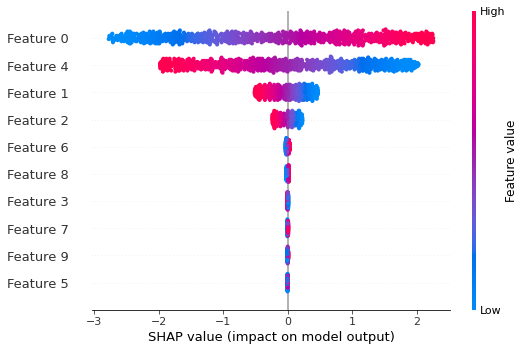

In [27]:
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)
explainer = shap.Explainer(model, X)#, feature_names=vectorizer.get_feature_names())
shap_values = explainer(X)
shap.summary_plot(shap_values, X)


## Neural Net

In [28]:

# rather than use the whole training set to estimate expected values, we summarize with
# a set of weighted kmeans, each weighted by the number of points they represent.
X_summary = shap.kmeans(X, 10)
explainer = shap.KernelExplainer(NN.predict, X_summary)
shap_values = explainer.shap_values(X) # only for a subset

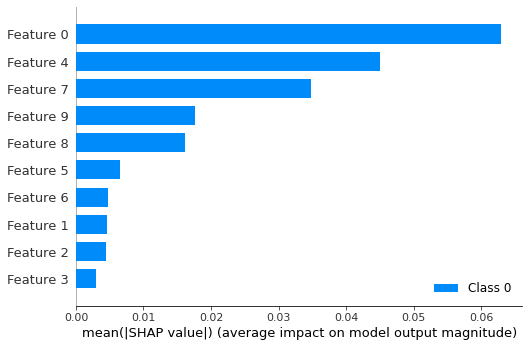

In [29]:
# for the entire data set
shap.summary_plot(shap_values, X)


In this particular example, the importance of Features 2 and 3 seems to not be captures by SHAP. This is probably because of the data reduction via shap.kmeans and due to the fact that out of the four relevant features, Feature 2 and 3 are the least relevant ones. However, I am not sure if the shap.kmeans function becomes reproducible via the random s

In [30]:
shap_values[0]

array([[-9.16232125e-02,  4.47697665e-03, -3.05204099e-04, ...,
         2.35801177e-02,  1.81567092e-02,  9.00128663e-04],
       [-3.93523440e-02, -2.57916098e-03, -8.30307637e-03, ...,
        -3.74588775e-02, -3.16983456e-02,  1.65437155e-02],
       [ 9.28513374e-02,  1.56977351e-03, -5.78951471e-03, ...,
         2.19764450e-04,  4.13054791e-02,  3.17967440e-02],
       ...,
       [-1.76935716e-02, -1.41103045e-03, -2.80939998e-03, ...,
        -6.18501312e-03, -1.40413161e-02, -1.04547906e-02],
       [-1.31317472e-01,  7.88850135e-05,  2.04544898e-03, ...,
         2.94173782e-02,  9.19326932e-03, -2.50121990e-02],
       [-6.59873346e-02, -3.12039489e-03, -1.13835261e-02, ...,
         4.09429176e-02,  1.86442581e-02, -1.38880650e-02]])

In [31]:
# for a single instance
shap.initjs() # needed for visualization 
shap.force_plot(explainer.expected_value,
                shap_values[0][0,:],
                X[0,:])
